# Getting Started: Pixel-Level Segmentation (Task 2)


This **Kasthuri Challenge** jupyter notebook takes you through how you can execute `task 2` by loading in the volume cutouts from BossDB (with visualization), training UNet, and evaluating the model with performance metrics.

For more details on the tasks and dataset, please refer to our paper:

    TBD

#### Install the required packages

In [15]:
#Note: Code is not public yet
#!git clone https://github.com/kasthuri_challenge && cd Kasthuri && pip install .

#### Import the required packages

In [2]:
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import numpy as np
import json as json
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp      
from sklearn.metrics import ConfusionMatrixDisplay
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

# BossDB library and Kasthuri dataset loader
from intern import array
from kasthuri.bossdbdataset import BossDBDataset               
from kasthuri.trainer import Trainer                    
from kasthuri.models.unet import UNet   

## Dataset Description

Bobby Kasthuri, Ph.D. under the tutelage of Jeff Lichtman, M.D., Ph.D., acquired a data set from mouse cortex with a 3x3x30 cubic nanometer spatial resolution, yielding 660GB of images. Using automated technologies to probe the structure of neural tissue at nanometer resolution, a saturated reconstruction of a sub-volume of mouse neocortex was generated in which all cellular objects (axons, dendrites, and glia) and many subcellular components (synapses, synaptic vesicles, spines, spine apparati, postsynaptic densities, and mitochondria) were rendered and itemized in a database. [[1]](#1)

#insert picture of the dataset here


The dataset and all corresponding labels are stored publicly in [BossDB](https://bossdb.org/project/kasthuri2015) and accessed on-demand with [Intern](https://pypi.org/project/intern/), a Python API library.

## Challenge Description

Kasthuri Challenge aims to generate annotations of a saturated reconstruction of a sub-volume of mouse neocortex imaged with a scanning electron microscope. Specifically, annotations of synapses and membranes are the regions of interest as they provide the best results and insights of how machine and deep learning are able pinpoint the unique connectivity at the microstructure level. [[2]](#2)



#### Train/Test Split

We use 300 images for train and 50 images for test, with a gap of 10 slices between datasets on the main subvolumes that are densely annotated at the pixel level. [[2]](#2)

|        | Train | Buffer  | Test    |
|:------:|:-----:|:-------:|:-------:|
| Slices | 0-299 | 300-309 | 310-359 |

All slices denoted as "train" are concatenated to form the train dataset, and all slices denoted as "test" are concatenated to form the test dataset.

<br>

<a id="1">[1]</a> Kasthuri N, Hayworth KJ, Berger DR, Schalek RL, Conchello JA, Knowles-Barley S, Lee D, Vázquez-Reina A, Kaynig V, Jones TR, Roberts M, Morgan JL, Tapia JC, Seung HS, Roncal WG, Vogelstein JT, Burns R, Sussman DL, Priebe CE, Pfister H, Lichtman JW. Saturated Reconstruction of a Volume of Neocortex. Cell. 2015 Jul 30;162(3):648-61. doi: 10.1016/j.cell.2015.06.054. PMID: 26232230.

<a id="2">[2]</a> Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track.

#### Specify the Dimensions to Train and the Number of Classes Here:

In [16]:
dimensions = 2      # 2 or 3
class_number = 2    # 3 or 4 (In 4 class case, ZI region is discarded)

## Loading Data

A BossDBDataset object is initialized with the task_config dictionary, the mode of data (`"train"`, `"test"`, `"val"`), and an optional transform function. A BossDBDataset object can be passed into a PyTorch DataLoader to properly split and load in the data into batches for training/testing.

The code for the BossDBDataset can be found [here](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/bossdbdataset.py).



In [17]:
root = "../kasthuri/"

with open(os.path.join(root, f"taskconfig/membrane_task.json")) as file:
    task_config = json.load(file)
    
# An additional 'transform' argument can be specified if needed.
train_data =  BossDBDataset(task_config, mode='train')
val_data = BossDBDataset(task_config, mode='val')
test_data =  BossDBDataset(task_config, mode='test')

## Data Visualization
#### Visualizing the First Slice and Its Groundtruth Annotation

Shape of input: torch.Size([1, 256, 256])
Shape of groundtruth annotations: torch.Size([256, 256])


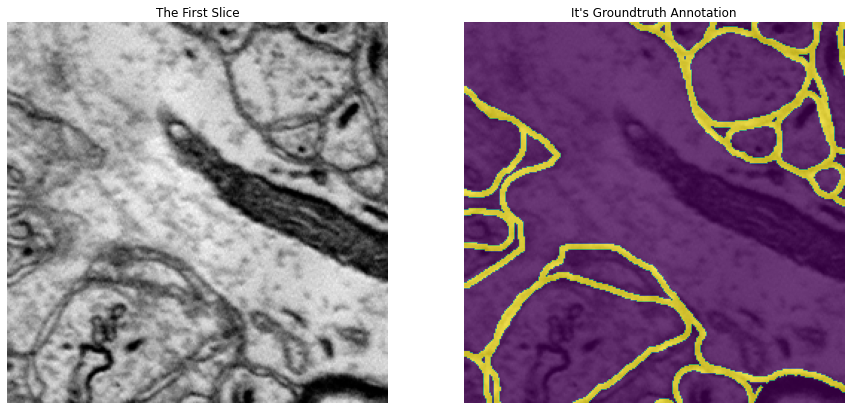

In [21]:
#Access the input and the groundtruth annotations of the first batch
input_data, annotations = train_data[0]
if dimensions == 3:
    input_data, annotations = input_data[0], annotations[0]

#Data Characteristics
print(f'Shape of input: {input_data.shape}')
print(f'Shape of groundtruth annotations: {annotations.shape}')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(input_data[0], cmap='gray')
ax1.title.set_text("The First Slice")
ax1.axis('off')

ax2.imshow(input_data[0], cmap='gray')
ax2.imshow(annotations.squeeze(), alpha = 0.75)
ax2.title.set_text("It's Groundtruth Annotation")
ax2.axis('off')

plt.show()

#### A Collage of Random Slices from the Training Data

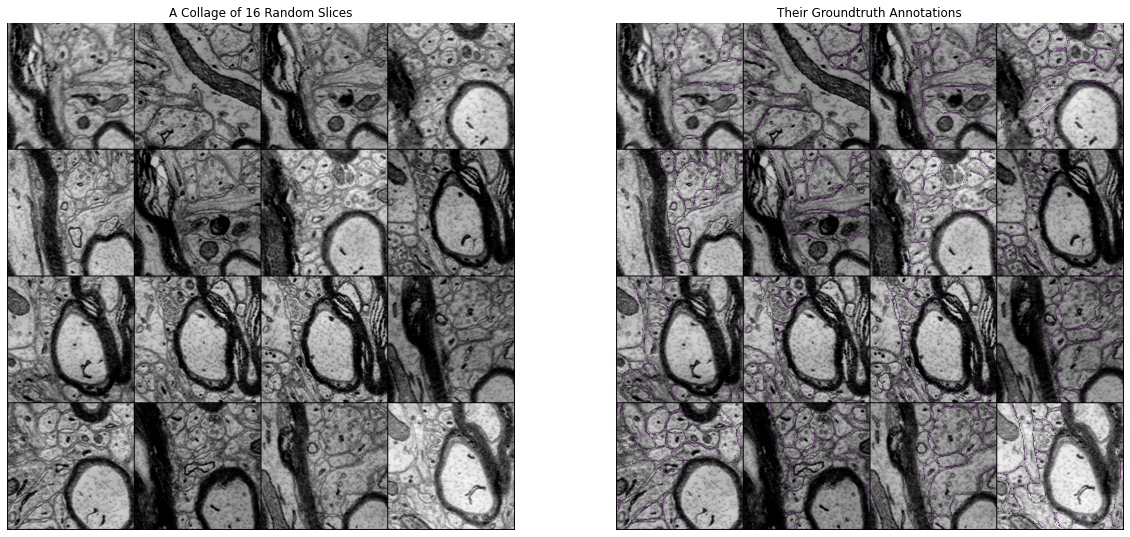

In [34]:
# Reshape data and select a random subset of 16 slices

reshaped_data = []
reshaped_annotations = []
if dimensions == 3:
    for data in train_data:
        reshaped_data = reshaped_data + list(data[0][0])
        reshaped_annotations = reshaped_annotations + list(data[1])
elif dimensions == 2:
    for data in train_data:
        reshaped_data = reshaped_data + [data[0][0]]
        reshaped_annotations = reshaped_annotations + [data[1]]
        
# Zip raw data and annotations together to use random.sample() once
random_samples = random.sample(list(zip(reshaped_data,reshaped_annotations)),16)

# Unzip random samples
random_samples_from_data = [random_data for random_data, random_annotations in random_samples]
random_samples_from_annotations = [random_annotations for random_data, random_annotations in random_samples]
    
grid_img_data = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=4)
grid_img_annotations = make_grid(torch.stack(random_samples_from_annotations).unsqueeze(1), nrow=4)
masked_annotations = np.ma.masked_where(grid_img_annotations == 0, grid_img_annotations)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(grid_img_data[0], cmap='gray')
ax1.title.set_text("A Collage of 16 Random Slices")
ax1.axis("off")

ax2.imshow(grid_img_data[0], cmap='gray')
ax2.imshow(masked_annotations[0], alpha = 0.5)
ax2.title.set_text("Their Groundtruth Annotations")
ax2.axis('off')
#ax2.legend(handles=legend_elements)

plt.show()

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the appropriate network configurations JSON files

with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D.json")) as file:
    network_config = json.load(file)

# Load the model with the configuration specified through the network configurations file.
print('Loading UNet Model')
model = UNet(in_channels = network_config['in_channels'],
             out_channels = network_config['classes'],
             n_blocks = network_config['n_blocks'],
             start_filters = network_config['start_filters'],
             activation = network_config['activation'],
             normalization = network_config['normalization'],
             conv_mode = network_config['conv_mode'],
             dim = network_config['dim']
            ).to(device)

Loading UNet Model


#### Setting the Loss Function and the Optimizer

In [8]:
# Loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (Utilizes the network config file)
if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))
 

#### Configuring the DataLoader

Documentation on the PyTorch DataLoader can be found [here](https://pytorch.org/docs/stable/data.html).

In [9]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=network_config['batch_size'],
                              shuffle=True)
validation_dataloader = DataLoader(dataset=val_data,
                                   batch_size=network_config['batch_size'],
                                   shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=network_config['batch_size'],
                             shuffle=True)

## Training the Model

The Trainer object assists with training a specified model with data that is feeded in through a DataLoader. Some of its initialization arguments are specified from this notebook, and some are specified through the network configuration JSON file. 

Trainer.run_trainer() initiates the model training process.

The script for Trainer can be found [here](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/trainer.py).

In [10]:
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=validation_dataloader,
                  epochs=network_config["epochs"],
                  notebook=True)

training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluating the Model

In [11]:
def predict(img, model, device):
    """Segments the pixels of a slice using a trained model.
    """
    model.eval()
    x = img.to(device)                     #send input to device
    with torch.inference_mode():
        out = model(x)                     #model forward pass
    out_argmax = torch.argmax(out, dim=1)  #perform softmax on outputs
    return out_argmax

#### Model Prediction

The trained model is tested with the test_dataloader that was initialized when the test dataset was downloaded from BossDB. We keep track of the true positive, false positive, false negative, and true negative scores in tensors for use later. 

In [12]:
# Variables for storing the True Postive, False Positive, False Negative and True Negative scores respectively
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

# Predict on test data
for x, y in test_dataloader:
    target = y.to(device) 
    # Segment the input image with the model
    output = predict(x, model, device)
    # Using segmentation_models_pytorch to calculate the statistics
    tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
    tp_tot = torch.vstack((tp_tot,tp))
    fp_tot = torch.vstack((fp_tot,fp))
    fn_tot = torch.vstack((fn_tot,fn))
    tn_tot = torch.vstack((tn_tot,tn))

#### Visualizing Model Predictions

One slice, its groundtruth annotation, and the model's predicted annotations are visualized below. Visualizations use the same legend and cmap as the visualizations in above cells.

**Note: If you observe any lack of quality in predictions, you can think of the number of epochs the training is run for. This can be set in the task config file which is being loaded**

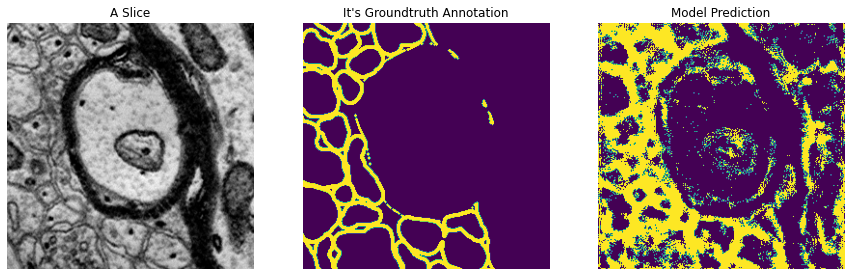

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x.squeeze()[0], cmap='gray')
ax1.title.set_text("A Slice")
ax1.axis('off')

ax2.imshow(y.squeeze()[0])  
ax2.title.set_text("It's Groundtruth Annotation")
ax2.axis('off')
#ax2.legend(handles=legend_elements) 

ax3.imshow(output.cpu().squeeze()[0]) 
ax3.title.set_text("Model Prediction")
ax3.axis('off')
#ax3.legend(handles=legend_elements) 

plt.show()

#### Calculating Performance Metrics

Metric Calculations:

$$
\begin{aligned}
\text{Accuracy: }&\frac{tp + tn}{fp + tn + fn + tp}\\\\
\text{Balanced Accuracy: }&\frac{\text{Specificity} + \text{Sensitivity}}{2}\\\\
\text{F1-Score: }&\frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}\\\\
\text{IoU: }&\frac{tp}{fp + fn + tp}
\end{aligned}
$$

Where tp = true positive, tn = true negative, fp = false positive, and fn = false negative.

In [14]:
# Accuracy
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('Accuracy per Class:', np.array(acc.cpu()))

# Balanced Accuracy
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'Balanced Accuracy (No Background): {balacc}')

# F1-score
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'F1-Score: {np.array(f1.cpu())}\nAvg. F1-Score: {f1.mean()}')

# IoU
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'IoU: {np.array(iou.cpu())}\nAvg. IoU-Score: {iou.mean()}')

Accuracy per Class: [0.7294068 0.7294068]
Balanced Accuracy (No Background): 0.7805782556533813
F1-Score: [0.8210647  0.44523212]
Avg. F1-Score: 0.6331484317779541
IoU: [0.69644594 0.28636563]
Avg. IoU-Score: 0.49140578508377075
